In [1]:
import gzip
import json
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.transforms import RandomNodeSplit
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GCNConv
from torch.nn import Linear, ModuleList
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

C:\Users\spenc\AppData\Local\Temp\ipykernel_39016\3134570862.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [81]:
import gzip


superblue = '../data/superblue18/1/superblue18.json.gz'
xbar = '../data/xbar/1/xbar.json.gz'

superblue_conn = '../data/superblue18/1/superblue18_connectivity.npz'
xbar_conn = '../data/xbar/1/xbar_connectivity.npz'

with gzip.open(xbar,'rb') as f:
    design = json.loads(f.read().decode('utf-8'))

instances = pd.DataFrame(design['instances'])
nets = pd.DataFrame(design['nets'])
conn=np.load(xbar_conn)

import torch

def coo_to_edge_index(coo_matrix):
    # Extract row indices (source nodes) and column indices (destination nodes)
    row_indices = torch.tensor(coo_matrix.row, dtype=torch.long)
    col_indices = torch.tensor(coo_matrix.col, dtype=torch.long)

    # Create edge_index tensor
    edge_index = torch.stack([row_indices, col_indices], dim=0)

    return edge_index

coo_matrix = torch.sparse_coo_tensor(indices=torch.tensor([conn['row'], conn['col']], dtype=torch.long),
                                      values=torch.tensor(conn['data'], dtype=torch.float))

coo_matrix.coalesce(), conn['row'], conn['row']


(tensor([[   0,    0,    0,  ..., 3950, 3951, 3951],
         [1526, 1535, 4481,  ..., 4481,    0, 4481]]),
 array([3951,  492,  941, ...,    2,    1,    0], dtype=int64),
 array([3951,  492,  941, ...,    2,    1,    0], dtype=int64))

In [53]:
instances = pd.DataFrame(design['instances'])
nets = pd.DataFrame(design['nets'])
conn=np.load('../data/superblue18/1/superblue18_connectivity.npz')

In [68]:
A = coo_matrix((conn['data'], (conn['row'], conn['col'])), shape=conn['shape'])

TypeError: 'Tensor' object is not callable

In [63]:
conn['row'], conn['col']

(array([224439, 224440, 224441, ..., 502055, 398820, 502056], dtype=int64),
 array([     0,      0,      0, ..., 511405, 511406, 511406], dtype=int64))

In [73]:
import torch

def coo_to_edge_index(coo_matrix):
    # Extract row indices (source nodes) and column indices (destination nodes)
    row_indices = torch.tensor(coo_matrix.row, dtype=torch.long)
    col_indices = torch.tensor(coo_matrix.col, dtype=torch.long)

    # Create edge_index tensor
    edge_index = torch.stack([row_indices, col_indices], dim=0)

    return edge_index

coo_matrix = torch.sparse_coo_tensor(indices=torch.tensor([conn['row'], conn['col']], dtype=torch.long),
                                      values=torch.tensor(conn['data'], dtype=torch.float))

coo_matrix.coalesce().indices()
# print(edge_index)

tensor([[     0,      0,      0,  ..., 502055, 502056, 502056],
        [331449, 331560, 331671,  ..., 511405,   1550, 511406]])

In [17]:
with gzip.open('../data/xbar/1/xbar.json.gz','rb') as f:
    design = json.loads(f.read().decode('utf-8'))

instances = pd.DataFrame(design['instances'])
nets = pd.DataFrame(design['nets'])

conn=np.load('../data/xbar/1/xbar_connectivity.npz')
A = coo_matrix((conn['data'], (conn['row'], conn['col'])), shape=conn['shape'])
A = A.__mul__(A.T)
def buildBST(array,start=0,finish=-1):
    if finish<0:
        finish = len(array)
    mid = (start + finish) // 2
    if mid-start==1:
        ltl=start
    else:
        ltl=buildBST(array,start,mid)
    
    if finish-mid==1:
        gtl=mid
    else:
        gtl=buildBST(array,mid,finish)
        
    return((array[mid],ltl,gtl))

congestion_data = np.load('../data/xbar/1/xbar_congestion.npz')
xbst=buildBST(congestion_data['xBoundaryList'])
ybst=buildBST(congestion_data['yBoundaryList'])
demand = np.zeros(shape = [instances.shape[0],])

def getGRCIndex(x,y,xbst,ybst):
    while (type(xbst)==tuple):
        if x < xbst[0]:
            xbst=xbst[1]
        else:
            xbst=xbst[2]
            
    while (type(ybst)==tuple):
        if y < ybst[0]:
            ybst=ybst[1]
        else:
            ybst=ybst[2]
            
    return ybst, xbst

grc_counts = {}
for k in range(instances.shape[0]):
    # print(k)
    xloc = instances.iloc[k]['xloc']; yloc = instances.iloc[k]['yloc']
    i,j=getGRCIndex(xloc,yloc,xbst,ybst)
    grc_counts[(i, j)] = grc_counts.get((i, j), 0) + 1

    d = 0 
    for l in list(congestion_data['layerList']): 
        lyr=list(congestion_data['layerList']).index(l)
        d += congestion_data['demand'][lyr][i][j]
    demand[k] = d
        
instances['routing_demand'] = demand

In [18]:
grc_counts_list = []

for k in range(instances.shape[0]):
    # Get the location of the instance
    xloc = instances.iloc[k]['xloc']
    yloc = instances.iloc[k]['yloc']

    # Get the GRC index of the instance
    i, j = getGRCIndex(xloc, yloc, xbst, ybst)

    # Get the count for the GRC index from the grc_counts dictionary
    count = grc_counts.get((i, j), 0)

    # Add the count to the list
    grc_counts_list.append(count)

# Add the list as a new column in the instances DataFrame
instances['grc_count'] = grc_counts_list

In [27]:
edge_index = from_scipy_sparse_matrix(A)
import torch
from torch_geometric.utils import degree

In [9]:
import matplotlib.pyplot as plt

In [33]:
import networkx as nx
G = nx.Graph(A)
betweenness = nx.betweenness_centrality(G)
clustering_coeff = nx.clustering(G)
pagerank = nx.pagerank(G)
eigenvector_centrality = nx.eigenvector_centrality_numpy(G)
degree = np.array(A.sum(axis=1)).flatten()

instances['betweenness'] = instances.index.map(betweenness)
instances['clustering_coeff'] = instances.index.map(clustering_coeff)
instances['pagerank'] = instances.index.map(pagerank)
instances['eigenvector_centrality'] = instances.index.map(eigenvector_centrality)
instances['degree'] = degree

                            xloc      yloc      cell    orient  grc_count  \
xloc                    1.000000 -0.024967  0.016961 -0.014932  -0.021522   
yloc                   -0.024967  1.000000 -0.024458  0.025120   0.062736   
cell                    0.016961 -0.024458  1.000000  0.010049  -0.028272   
orient                 -0.014932  0.025120  0.010049  1.000000   0.003245   
grc_count              -0.021522  0.062736 -0.028272  0.003245   1.000000   
degree                  0.088868 -0.078620 -0.098379  0.012791  -0.223872   
betweenness            -0.098728  0.105847 -0.056345 -0.024375   0.100231   
clustering_coeff       -0.016262  0.027669 -0.066404 -0.009184  -0.103198   
pagerank                0.060431 -0.063312 -0.094837  0.011862  -0.156450   
eigenvector_centrality -0.074996  0.074052  0.075349 -0.006057   0.182369   
routing_demand         -0.121477  0.115409 -0.227863 -0.015444   0.300263   

                          degree  betweenness  clustering_coeff  pagerank  

<Axes: >

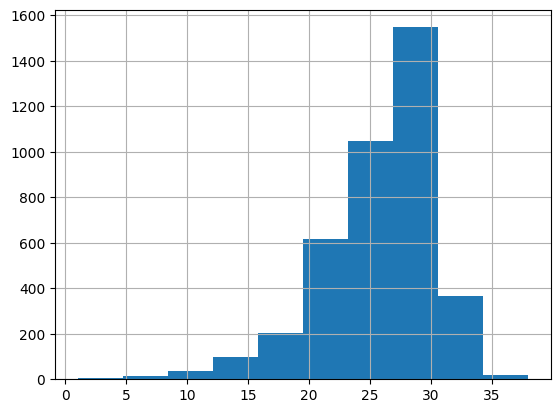

In [37]:
correlation_matrix = instances['orient','grc_count', 'degree', 'betweenness', 'clustering_coeff', 'pagerank', 'eigenvector_centrality', 'routing_demand']].corr()
print(correlation_matrix)a
instances['routing_demand'].hist()

In [5]:
torch.manual_seed(42) # for replication
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = torch.tensor(instances[['xloc', 'yloc', 'cell', 'orient']].values)
y = torch.tensor(instances['routing_demand'].values)
ei = from_scipy_sparse_matrix(A)
edge_index = ei[0]
data = Data(x=X, edge_index=edge_index, y=y)
split = RandomNodeSplit(num_splits=1, num_val=0.0, num_test=0.3)
split_data = split(data)
train = torch.argwhere(split_data.train_mask).reshape(-1)
test = torch.argwhere(split_data.test_mask).reshape(-1)
train_mapping = {a.item():b for a,b in zip(train, range(train.shape[0]))}
test_mapping = {a.item():b for a,b in zip(test, range(test.shape[0]))}
X_train = split_data.x[split_data.train_mask].float()
X_test = split_data.x[split_data.test_mask].float()
y_train = split_data.y[split_data.train_mask].float()
y_test = split_data.y[split_data.test_mask].float()
edge_index_train = torch.tensor([train_mapping[i.item()] for i in edge_index[:,torch.argwhere(torch.all(torch.isin(edge_index, torch.argwhere(split_data.train_mask).reshape(-1)), dim=0)).reshape(-1)].reshape(-1)]).reshape(2, edge_index[:,torch.argwhere(torch.all(torch.isin(edge_index, torch.argwhere(split_data.train_mask).reshape(-1)), dim=0)).reshape(-1)].shape[1])
edge_index_test = torch.tensor([test_mapping[i.item()] for i in edge_index[:,torch.argwhere(torch.all(torch.isin(edge_index, torch.argwhere(split_data.test_mask).reshape(-1)), dim=0)).reshape(-1)].reshape(-1)]).reshape(2, edge_index[:,torch.argwhere(torch.all(torch.isin(edge_index, torch.argwhere(split_data.test_mask).reshape(-1)), dim=0)).reshape(-1)].shape[1])
final_train = Data(x=X_train, edge_index=edge_index_train, y=y_train)
final_test = Data(x=X_test, edge_index=edge_index_test, y=y_test)

In [4]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(final_train.x.numpy(), final_train.y.numpy().ravel())
predictions = rf_regressor.predict(final_test.x.numpy())
mse = mean_squared_error(final_test.y.numpy().ravel(), predictions)
r2 = r2_score(final_test.y.numpy().ravel(), predictions)
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared Score: {r2}')

Mean Squared Error (MSE): 5.8637880269814495
R-squared Score: 0.715635352019881


In [8]:
torch.manual_seed(42) # for replication
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = torch.tensor(instances[['xloc', 'yloc', 'cell', 'orient']].values)
y = torch.tensor(instances['routing_demand'].values)
ei = from_scipy_sparse_matrix(A)
edge_index = ei[0]
data = Data(x=X, edge_index=edge_index, y=y)
split = RandomNodeSplit(num_splits=1, num_val=0.0, num_test=0.3)
split_data = split(data)
train = torch.argwhere(split_data.train_mask).reshape(-1).to(device)
test = torch.argwhere(split_data.test_mask).reshape(-1).to(device)
train_mapping = {a.item():b for a,b in zip(train, range(train.shape[0]))}
test_mapping = {a.item():b for a,b in zip(test, range(test.shape[0]))}
X_train = split_data.x[split_data.train_mask].float().to(device)
X_test = split_data.x[split_data.test_mask].float().to(device)
y_train = split_data.y[split_data.train_mask].float().to(device)
y_test = split_data.y[split_data.test_mask].float().to(device)
edge_index_train = torch.tensor([train_mapping[i.item()] for i in edge_index[:,torch.argwhere(torch.all(torch.isin(edge_index, torch.argwhere(split_data.train_mask).reshape(-1)), dim=0)).reshape(-1)].reshape(-1)]).reshape(2, edge_index[:,torch.argwhere(torch.all(torch.isin(edge_index, torch.argwhere(split_data.train_mask).reshape(-1)), dim=0)).reshape(-1)].shape[1]).to(device)
edge_index_test = torch.tensor([test_mapping[i.item()] for i in edge_index[:,torch.argwhere(torch.all(torch.isin(edge_index, torch.argwhere(split_data.test_mask).reshape(-1)), dim=0)).reshape(-1)].reshape(-1)]).reshape(2, edge_index[:,torch.argwhere(torch.all(torch.isin(edge_index, torch.argwhere(split_data.test_mask).reshape(-1)), dim=0)).reshape(-1)].shape[1]).to(device)
final_train = Data(x=X_train, edge_index=edge_index_train, y=y_train).to(device)
final_test = Data(x=X_test, edge_index=edge_index_test, y=y_test).to(device)

In [24]:
final_train.y.mean()

tensor(25.6001)

In [17]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_hidden_layers, hidden_channels):
        super(GCN, self).__init__()
        self.gcn = GCNConv(num_features, hidden_channels)
        self.hidden_layers = ModuleList([GCNConv(hidden_channels, hidden_channels) for _ in range(num_hidden_layers)])
        self.out = Linear(hidden_channels, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.gcn(x, edge_index))
        for layer in self.hidden_layers:
            x = F.relu(layer(x, edge_index))
        x = self.out(x)
        return x 
    
    def adjust_learning_rate(optimizer, epoch):
        """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
        lr = 0.01 * (0.1 ** (epoch // 30))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

In [19]:
def train(model, data):
    data = data.to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        z = model(data)
        z = z.to(device)
        loss = criterion(z.squeeze(), data.y.float())
        loss.backward()
        optimizer.step()
        # adjust_learning_rate(optimizer, epoch)

        if epoch % 10 == 0:
            print(f'Epoch {epoch:>3} | Loss: {loss:.2f}')

def test_mse(model, test_data):
    model.eval()
    with torch.no_grad():
        test_data = test_data.to(device)
        predictions = model(test_data)
        mse = F.mse_loss(predictions.squeeze(), test_data.y.float())
    return mse.item()

In [23]:
one_layer_model = GCN(num_features=final_train.x.shape[1], num_hidden_layers=0, hidden_channels=768).to(device)
train(one_layer_model, final_train)
print(test_mse(one_layer_model, final_test))

Epoch   0 | Loss: 538598.50
Epoch  10 | Loss: 403503.06
Epoch  20 | Loss: 638.36
Epoch  30 | Loss: 702.46
Epoch  40 | Loss: 690.02
Epoch  50 | Loss: 682.60
Epoch  60 | Loss: 679.60
Epoch  70 | Loss: 678.60
Epoch  80 | Loss: 678.18
Epoch  90 | Loss: 677.94
Epoch 100 | Loss: 677.76
Epoch 110 | Loss: 677.59
Epoch 120 | Loss: 677.43
Epoch 130 | Loss: 677.26
Epoch 140 | Loss: 677.09
Epoch 150 | Loss: 676.92
Epoch 160 | Loss: 676.75
Epoch 170 | Loss: 676.57
Epoch 180 | Loss: 676.39
Epoch 190 | Loss: 676.21
684.3212280273438


In [21]:
two_layer_model = GCN(num_features=final_train.x.shape[1], num_hidden_layers=4, hidden_channels=768).to(device)
train(two_layer_model, final_train)
print(test_mse(two_layer_model, final_test))

Epoch   0 | Loss: 9257.52


KeyboardInterrupt: 

In [11]:
three_layer_model = GCN(num_features=final_train.x.shape[1], num_hidden_layers=2, hidden_channels=768).to(device)
train(three_layer_model, final_train)
print(test_mse(three_layer_model, final_test))

Epoch   0 | Loss: 75017.96
Epoch  10 | Loss: 19329.09
Epoch  20 | Loss: 222.28
Epoch  30 | Loss: 459.79
Epoch  40 | Loss: 79.16
Epoch  50 | Loss: 50.73
Epoch  60 | Loss: 57.64
Epoch  70 | Loss: 54.74
Epoch  80 | Loss: 51.00
Epoch  90 | Loss: 49.64
Epoch 100 | Loss: 49.40
Epoch 110 | Loss: 49.19
Epoch 120 | Loss: 48.93
Epoch 130 | Loss: 48.64
Epoch 140 | Loss: 48.33
Epoch 150 | Loss: 47.98
Epoch 160 | Loss: 47.59
Epoch 170 | Loss: 47.16
Epoch 180 | Loss: 46.68
Epoch 190 | Loss: 46.15
36.135929107666016


In [12]:
def baseline_model_pytorch(data):
    device = "cuda" if torch.cuda.is_available() else "cpu"  # Automatically choose the device
    data = data.to(device)  # Ensure the data is on the correct device
    train_mean = data.y.float().mean()  # Calculate mean over all data.y
    baseline_predictions = torch.full_like(data.y, train_mean, device=device)  # Ensure this tensor is on GPU
    mse = F.mse_loss(baseline_predictions, data.y.float())  # Calculate MSE over all data.y
    return mse.item()

In [13]:
train_mse_baseline = baseline_model_pytorch(final_train)
test_mse_baseline = baseline_model_pytorch(final_test)

print(f"Baseline Training MSE: {train_mse_baseline}")
print(f"Baseline Test MSE: {test_mse_baseline}")

Baseline Training MSE: 20.35999870300293
Baseline Test MSE: 20.62066650390625
